In [19]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
def Overwrite_Initial_L_SEI_0_Neg_Porosity(Para_0,cap_loss):
    """
    This is to overwrite the initial negative electrode porosity
    and initial SEI thickness (inner, outer) to be consistent
    with the initial capacity loss
    """
    delta_Q_SEI = cap_loss * 3600
    V_SEI = Para_0["Negative outer SEI partial molar volume [m3.mol-1]"]
    # do this when finish updating
    F = 96485.3
    A = Para_0["Electrode width [m]"] * Para_0["Electrode height [m]"]
    z_SEI = Para_0["Negative ratio of lithium moles to SEI moles"]
    L_neg = Para_0["Negative electrode thickness [m]"]
    eps_act_neg = Para_0["Negative electrode active material volume fraction"]
    R_neg =   Para_0["Negative particle radius [m]"]
    l_cr_init = Para_0["Negative electrode initial crack length [m]"]
    w_cr = Para_0["Negative electrode initial crack width [m]"]
    rho_cr = Para_0["Negative electrode number of cracks per unit area [m-2]"]
    a_neg = (3 * eps_act_neg / R_neg)
    roughness = 1 + 2 * l_cr_init * w_cr * rho_cr
    L_SEI_init = delta_Q_SEI  * V_SEI / (
        z_SEI * F * A * L_neg * a_neg * roughness)
 
    delta_epi = (L_SEI_init ) * roughness * a_neg
    L_inner_init = L_SEI_init / 2
    epi = 0.25 - delta_epi
    # print(L_inner_init,epi)
    # important: update here!
    Para_0["Negative electrode porosity"] = epi
    Para_0["Negative initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Negative initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    ## add Xinlei
    Para_0["Initial inner SEI thickness [m]"] = L_inner_init + 2.5e-9
    Para_0["Initial outer SEI thickness [m]"] = L_inner_init + 2.5e-9
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
    print(f"Has Overwritten Initial outer SEI thickness [m] to be {(L_inner_init+2.5e-9):.2e} and Negative electrode porosity to be {epi:.3f} to account for initial capacity loss of {cap_loss:.3f} Ah")
 
    return Para_0

param = pybamm.ParameterValues("OKane2023_Xinlei")

Overwrite_Initial_L_SEI_0_Neg_Porosity(param,0.15)

Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah
Has Overwritten Initial outer SEI thickness [m] to be 1.62e-08 and Negative electrode porosity to be 0.219 to account for initial capacity loss of 0.150 Ah


{'Ambient temperature [K]': 298.15,
 'Boltzmann constant [J.K-1]': 1.380649e-23,
 'Bulk solvent concentration [mol.m-3]': 2636.0,
 'Cation transference number': <function electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Constant at 0x7fc7a2d4cd30>,
 'Cell cooling surface area [m2]': 0.00531,
 'Cell thermal expansion coefficient [m.K-1]': 1.1e-06,
 'Cell volume [m3]': 2.42e-05,
 'Contact resistance [Ohm]': 0.013,
 'Current function [A]': 5.0,
 'Dead lithium decay constant [s-1]': 1e-06,
 'Dead lithium decay rate [s-1]': <function SEI_limited_dead_lithium_OKane2022 at 0x7fc7a2d4c040>,
 'EC diffusivity [m2.s-1]': 2e-18,
 'EC initial concentration in electrolyte [mol.m-3]': 4541.0,
 'EC partial molar volume [m3.mol-1]': 6.667e-05,
 'Electrode height [m]': 0.065,
 'Electrode width [m]': 1.58,
 'Electrolyte conductivity [S.m-1]': <function electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Constant at 0x7fc7a2d4cee0>,
 'Electrolyte diffusivity [m2.s-1]': <function electrolyte_diff

In [20]:
print(param["Initial concentration in negative electrode [mol.m-3]"])
param["Initial concentration in negative electrode [mol.m-3]"] = 28600
print(param["Initial concentration in negative electrode [mol.m-3]"])



print(param["Initial concentration in positive electrode [mol.m-3]"])
param["Initial concentration in positive electrode [mol.m-3]"] = 13100
print(param["Initial concentration in positive electrode [mol.m-3]"])

28800
28600
12729.0
13100


In [21]:
print(param["Total heat transfer coefficient [W.m-2.K-1]"])
param["Total heat transfer coefficient [W.m-2.K-1]"] =15
print(param["Total heat transfer coefficient [W.m-2.K-1]"])

15.0
15


In [22]:
# 从sol中计算循环过程中的容量，需要调整step如果换了工步
def calculate_capacities(sol):
    # 初始化充电容量和放电容量列表
    charge_capacities = []
    discharge_capacities = []

    # 遍历sol数据结构中的每个循环
    for cycle in sol.cycles:
        # 获取第一个步骤的放电容量时间序列
        step1_times = cycle.steps[0]["Discharge capacity [A.h]"].entries
        # 获取第二个步骤的放电容量时间序列
        step2_times = cycle.steps[1]["Discharge capacity [A.h]"].entries
        # 获取第三个步骤的放电容量时间序列
        step3_times = cycle.steps[2]["Discharge capacity [A.h]"].entries

        # 计算第一个步骤的初始值和第二个步骤的最后值的差（充电容量）
        charge_capacity = step2_times[-1] - step1_times[0]
        charge_capacities.append((-1) * charge_capacity)
        
        # 计算第三步的初始值和最后值的差（放电容量）
        discharge_capacity = step3_times[-1] - step3_times[0]
        discharge_capacities.append(discharge_capacity)

    # 返回计算结果
    return charge_capacities, discharge_capacities

In [23]:

import pybamm
import matplotlib.pyplot as plt
import numpy as np


model_nodeg = pybamm.lithium_ion.SPM(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        # "SEI": "solvent-diffusion limited",
        # "SEI porosity change": "true",
        # "lithium plating": "partially reversible",
        # "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        # "particle mechanics": ("swelling and cracking", "swelling only"),
        # "SEI on cracks": "true",
        # "loss of active material": "stress-driven",
        # "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 120,  # negative particle
    "r_p": 100,  # positive particle
}

cycle_number = 3
exp_breakin = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until C/50",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Hold at 2.6V for 1 hours"],  # final capacity check
)





sim_nodeg_breakin = pybamm.Simulation(model_nodeg, parameter_values=param, experiment=exp_breakin, var_pts=var_pts )
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol_nodeg_breakin = sim_nodeg_breakin.solve(initial_soc=0)
#sol = sim.solve()



In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cwd = os.getcwd()


# 读取 pickle 文件
#pickle_file_path = cwd + '/docs/source/examples/notebooks/models/exp_LG/processed_data.pkl'
pickle_file_path = cwd + '/exp_LG/processed_data.pkl'
cycles_df = pd.read_pickle(pickle_file_path)
print("DataFrame loaded from pickle file")
print(cycles_df.head())


# 提取每个循环的最后一个 Q_dis 和 Q_cha 非零值
summary_data = []

for cycle in cycles_df.index.levels[0]:
    cycle_data = cycles_df.loc[cycle]
    last_q_dis = cycle_data[cycle_data['Q_dis'] > 0]['Q_dis'].iloc[-1] if not cycle_data[cycle_data['Q_dis'] > 0].empty else 0
    last_q_cha = cycle_data[cycle_data['Q_cha'] > 0]['Q_cha'].iloc[-1] if not cycle_data[cycle_data['Q_cha'] > 0].empty else 0
    summary_data.append([cycle, last_q_cha, last_q_dis])

# 创建一个新的 DataFrame 存储结果
summary_df = pd.DataFrame(summary_data, columns=['Cycle', 'Last_Q_cha', 'Last_Q_dis'])




DataFrame loaded from pickle file
            Mode  RelativeTime   Voltage          I  Q_dis     Q_cha  \
Cycle Step                                                             
1     1      1.0        0.0000  2.680430  1407.8055    0.0  0.000078   
      2      1.0        0.0084  2.690530  1574.4427    0.0  0.003691   
      3      1.0        0.0294  2.700598  1640.2499    0.0  0.013108   
      4      1.0        0.0634  2.710643  1664.4644    0.0  0.028749   
      5      1.0        0.1074  2.720645  1668.5892    0.0  0.049123   

                 Cap         R    Pressure  Temperature  
Cycle Step                                               
1     1     0.000078  1.903978  159.026607      25.3794  
      2     0.003691  1.708878  158.944819      25.3885  
      3     0.013108  1.646455  158.998347      25.4014  
      4     0.028749  1.628537  159.049016      25.4088  
      5     0.049123  1.630506  158.990980      25.4014  


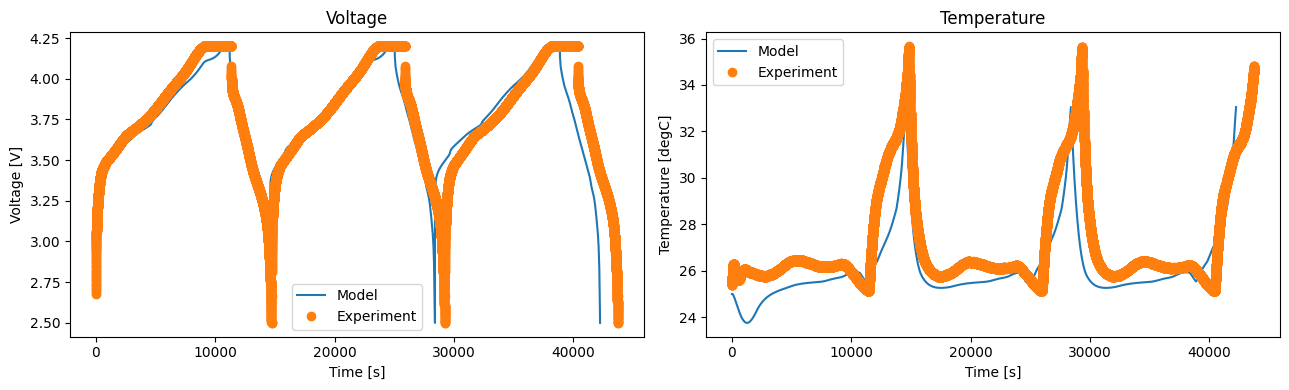

In [25]:
# Merge the first two cycles for Voltage and Temperature
merged_cycles_voltage = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_voltage = pd.concat([cycles_df.loc[1]["Voltage"], cycles_df.loc[2]["Voltage"],cycles_df.loc[3]["Voltage"]])

merged_cycles_temperature = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_temperature = pd.concat([cycles_df.loc[1]["Temperature"], cycles_df.loc[2]["Temperature"], cycles_df.loc[3]["Temperature"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol_nodeg = sol_nodeg_breakin["Time [s]"].entries

ax1.plot(t_sol_nodeg, sol_nodeg_breakin["Voltage [V]"](t_sol_nodeg))
ax1.plot(merged_cycles_voltage, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol_nodeg, sol_nodeg_breakin["X-averaged cell temperature [C]"](t_sol_nodeg))
ax2.plot(merged_cycles_temperature, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

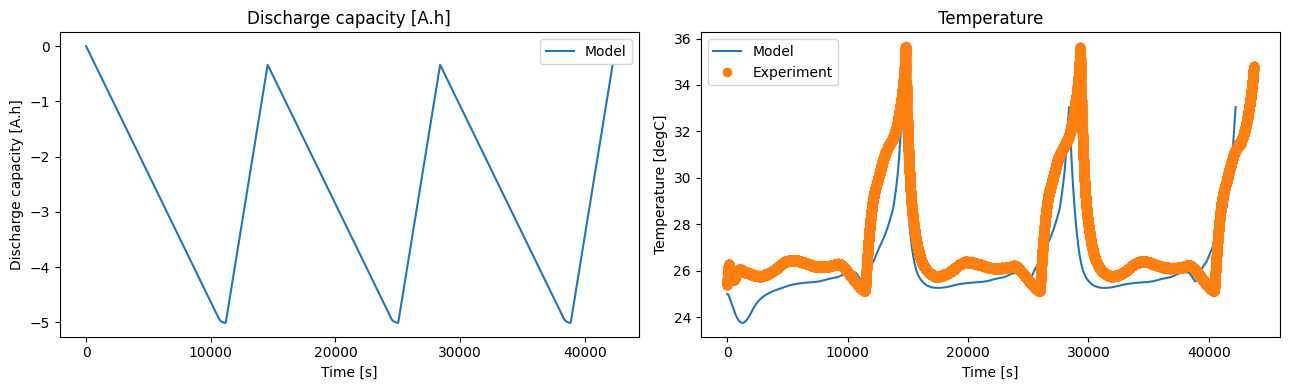

In [26]:
# Merge the first two cycles for Voltage and Temperature
merged_cycles_voltage = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_voltage = pd.concat([cycles_df.loc[1]["Voltage"], cycles_df.loc[2]["Voltage"],cycles_df.loc[3]["Voltage"]])

merged_cycles_temperature = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_temperature = pd.concat([cycles_df.loc[1]["Temperature"], cycles_df.loc[2]["Temperature"], cycles_df.loc[3]["Temperature"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol_nodeg = sol_nodeg_breakin["Time [s]"].entries

ax1.plot(t_sol_nodeg, sol_nodeg_breakin["Discharge capacity [A.h]"](t_sol_nodeg))
#ax1.plot(merged_cycles_voltage, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Discharge capacity [A.h]")
ax1.set_title("Discharge capacity [A.h]")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol_nodeg, sol_nodeg_breakin["X-averaged cell temperature [C]"](t_sol_nodeg))
ax2.plot(merged_cycles_temperature, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [27]:
sol_nodeg_breakin["Discharge capacity [A.h]"].entries

array([ 0.        , -0.02777778, -0.05555556, -0.08333333, -0.11111111,
       -0.13888889, -0.16666667, -0.19444444, -0.22222222, -0.25      ,
       -0.27777778, -0.30555556, -0.33333333, -0.36111111, -0.38888889,
       -0.41666667, -0.44444444, -0.47222222, -0.5       , -0.52777778,
       -0.55555556, -0.58333333, -0.61111111, -0.63888889, -0.66666667,
       -0.69444444, -0.72222222, -0.75      , -0.77777778, -0.80555556,
       -0.83333333, -0.86111111, -0.88888889, -0.91666667, -0.94444444,
       -0.97222222, -1.        , -1.02777778, -1.05555556, -1.08333333,
       -1.11111111, -1.13888889, -1.16666667, -1.19444444, -1.22222222,
       -1.25      , -1.27777778, -1.30555556, -1.33333333, -1.36111111,
       -1.38888889, -1.41666667, -1.44444444, -1.47222222, -1.5       ,
       -1.52777778, -1.55555556, -1.58333333, -1.61111111, -1.63888889,
       -1.66666667, -1.69444444, -1.72222222, -1.75      , -1.77777778,
       -1.80555556, -1.83333333, -1.86111111, -1.88888889, -1.91

In [28]:
charge_capacities, discharge_capacities = calculate_capacities(sol_nodeg_breakin)

In [29]:
charge_capacities

[5.007637479358075, 4.670692225742205, 4.670691569201261]

In [30]:

discharge_capacities

[4.67069227995557, 4.6706913978365465, 4.670691522872493]

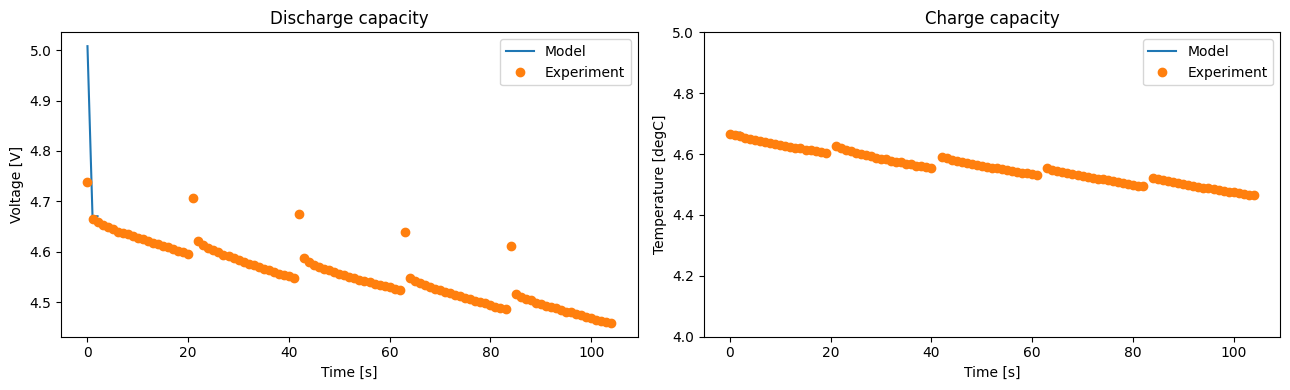

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol_nodeg_breakin["Time [s]"].entries

ax1.plot(charge_capacities)
ax1.plot(summary_df["Last_Q_cha"]/1000, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Discharge capacity")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(discharge_capacities)
ax2.plot(summary_df["Last_Q_dis"]/1000, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Charge capacity")
ax2.set_ylim(4,5)
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [32]:
model = pybamm.lithium_ion.SPM(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        "open-circuit potential": "current sigmoid",
        "SEI": "solvent-diffusion limited",
        #"SEI": "interstitial-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

#param = pybamm.ParameterValues("OKane2023_Xinlei")

var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 120,  # negative particle
    "r_p": 100,  # positive particle
}

cycle_number = 3
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Charge at C/3 until 4.2 V",
            "Hold at 4.2 V until C/20",
            "Discharge at 1C until 2.5 V",  # ageing cycles
            #"Discharge at 1C until 2.5 V"

        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# exp = pybamm.Experiment(
#     [
#         "Hold at 4.2 V until C/100 (5 minute period)",
#         "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
#         "Charge at 0.1C until 4.2 V (5 minute period)",
#         "Hold at 4.2 V until C/100 (5 minute period)",
#     ]
# )


sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts )
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve(initial_soc=0)
#sol = sim.solve()


At t = 101.381 repeated recoverable right-hand side function errors.
At t = 101.381 repeated recoverable right-hand side function errors.
At t = 101.381 repeated recoverable right-hand side function errors.
At t = 41.3171 repeated recoverable right-hand side function errors.
At t = 101.404, mxstep steps taken before reaching tout.
At t = 101.404, mxstep steps taken before reaching tout.
At t = 101.404, mxstep steps taken before reaching tout.
At t = 38.2686, mxstep steps taken before reaching tout.
At t = 95.2317 repeated recoverable right-hand side function errors.
At t = 95.2317 repeated recoverable right-hand side function errors.
At t = 95.2317 repeated recoverable right-hand side function errors.


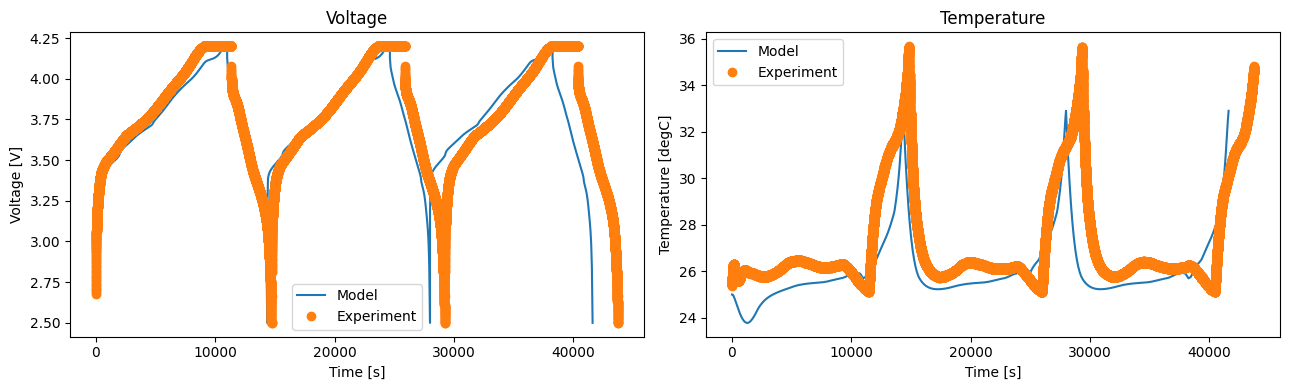

In [33]:
# Merge the first two cycles for Voltage and Temperature
merged_cycles_voltage = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                   cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_voltage = pd.concat([cycles_df.loc[1]["Voltage"], cycles_df.loc[2]["Voltage"],cycles_df.loc[3]["Voltage"]])

merged_cycles_temperature = pd.concat([cycles_df.loc[1]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1], 
                                       cycles_df.loc[2]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1],
                                       cycles_df.loc[3]["RelativeTime"]-cycles_df.loc[1]["RelativeTime"].iloc[1]])
merged_temperature = pd.concat([cycles_df.loc[1]["Temperature"], cycles_df.loc[2]["Temperature"], cycles_df.loc[3]["Temperature"]])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(t_sol, sol["Voltage [V]"](t_sol))
ax1.plot(merged_cycles_voltage, merged_voltage, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Voltage")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(t_sol, sol["X-averaged cell temperature [C]"](t_sol))
ax2.plot(merged_cycles_temperature, merged_temperature, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Temperature")
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [34]:
charge_capacities_1, discharge_capacities_1 = calculate_capacities(sol)

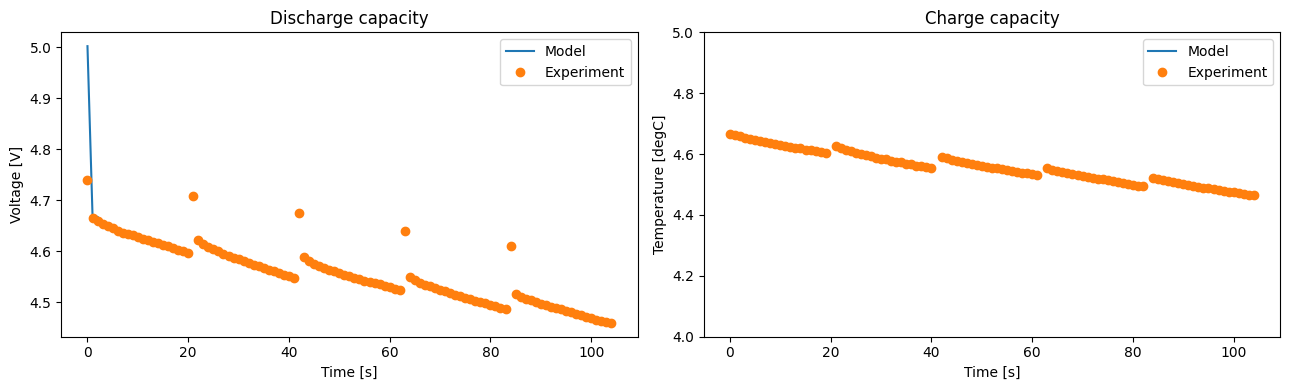

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# plot the 1C results
t_sol = sol["Time [s]"].entries

ax1.plot(charge_capacities_1)
ax1.plot(summary_df["Last_Q_cha"]/1000, "o")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Discharge capacity")
ax1.legend(["Model", "Experiment"], loc="best")

ax2.plot(discharge_capacities_1)
ax2.plot(summary_df["Last_Q_dis"]/1000, "o")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Temperature [degC]")
ax2.set_title("Charge capacity")
ax2.set_ylim(4,5)
ax2.legend(["Model", "Experiment"], loc="best")

plt.tight_layout()
plt.show()

In [36]:
sol.summary_variables

{'Time [s]': array([14351.49920159, 27985.77256531, 41608.4092199 ]),
 'Change in time [s]': array([14351.49920159, 13634.27336371, 13622.63665459]),
 'Time [h]': array([ 3.98652756,  7.77382571, 11.55789145]),
 'Change in time [h]': array([3.98652756, 3.78729816, 3.78406574]),
 'Throughput capacity [A.h]': array([ 9.67317124, 19.01152437, 28.34172502]),
 'Change in throughput capacity [A.h]': array([9.67317124, 9.33835314, 9.33020064]),
 'Throughput energy [W.h]': array([ 35.82806189,  70.51453069, 105.17304071]),
 'Change in throughput energy [W.h]': array([35.82806189, 34.6864688 , 34.65851003]),
 'Loss of lithium inventory [%]': array([0.0640582 , 0.1281796 , 0.19243697]),
 'Change in loss of lithium inventory [%]': array([0.0640582 , 0.0641214 , 0.06425736]),
 'Loss of lithium inventory, including electrolyte [%]': array([0.06280385, 0.12566966, 0.18866878]),
 'Change in loss of lithium inventory, including electrolyte [%]': array([0.06280385, 0.06286581, 0.06299911]),
 'Total lit